# BPZ RAIL - DP0.1

## Imports

### common libs

In [2]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline 

### RAIL

RAIL is a LSST-DESC software created to process different algorithms used to calculate photometric redshift. Its main goal is to minimize impact that different infrastructures can cause on different algorithms, for that it unifyes in a modular code supporting different inputs that different algorithms needs and padronizing the output so that it can be a more fair comparison between their results.

Rail uses 4 principal libraries in its core: <br>
_tables_io_: for data manipulation as hdf5 files, fits, etc. <br>
_qp_: used to paremitrize data PDFs for metrics calculation. <br>
_ceci_: construct pipelines, produces a .yaml within the steps and configurations as threads. <br>
_pzflow_: creates a flow for data creation. <br>

#### Core.
Where the main functions are going to manage the data and files that the program creates. It works based in the behavioral chain of resposability pattern (https://refactoring.guru/pt-br/design-patterns/chain-of-responsibility), where you create a flux in the code, where there is a request related/processed by a class handler that decides to pass it foward or not according to what is defined. So for that, what bpz does is create a class request (eg: Inform_BPZ_lite) that has all the inputs/configurations and is handled by its class handler (BPZ_lite).

#### Creation.
Contain all the support for data creation, as degradors, data flow creation, Column remapping, etc. It creates .hdf5 files with the data that is being manipulated.

#### Estimation.
This is where the codes are defined and executed.  <br>
inform: this is where the PRIORS for template fitting are informed and the machine learning codes are trained. <br>
estimate: where the algorith is executed though the .evaluate() function.
The code is wrapped as a RAIL stage so that it can be run in a controlled way. Estimation code can be stored in a yaml file to be run as a ceci module.


#### Evaluation.
This step contais the metrics for performance of the estimated codes.
<br>
------
For installation instructions check the official documentation: https://lsstdescrail.readthedocs.io/en/latest/source/installation.html <br>
For Rail versions check: https://github.com/LSSTDESC/RAIL/releases

In [3]:
import rail
import qp
import tables_io

from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

##from rail.creation.engines.flowEngine import FlowEngine, FlowPosterior

from rail.estimation.algos.bpz_lite import Inform_BPZ_lite, BPZ_lite

from rail.evaluation.evaluator import Evaluator

#for rail versions
help(rail)

Help on package rail:

NAME
    rail - RAIL, the Redshift Assesement Infrastructre Layers

PACKAGE CONTENTS
    __main__
    _version
    core (package)
    creation (package)
    estimation (package)
    evaluation (package)
    main
    version

VERSION
    0.96.dev326+ge3e6ed6

FILE
    /home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/__init__.py




## General Configs

Setting some default number of rows for pandas. So that it doesnt display all of them. 

In [4]:
pd.set_option('display.max_rows', 10)

Defining some variables that will help us with directories. 

In [5]:
CURR_DIR = os.getcwd()
RAIL_DIR = os.path.join(os.path.dirname(rail.__file__), '..')
CURR_DIR, RAIL_DIR

('/home/heloisamengisztki/ic-photoz/Fase 2 - RAIL/bpz_test_rail',
 '/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/..')

In [6]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Reading DP0.1 csv

In [7]:
dp01_headers = [
"coadd_objects_id",
"ra",
"dec",
"mag_g",
"magerr_g",
"mag_i",
"magerr_i",
"mag_r",
"magerr_r",
"mag_u",
"magerr_u",
"mag_y",
"magerr_y",
"mag_z",
"magerr_z",
"z_true"
]

trainFile = os.path.join(CURR_DIR, 'dp0_train_random.csv')
full_data = pd.read_csv(trainFile)

In [8]:
full_data = full_data[dp01_headers]
full_data

,coadd_objects_id,ra,dec,mag_g,magerr_g,mag_i,magerr_i,mag_r,magerr_r,mag_u,magerr_u,mag_y,magerr_y,mag_z,magerr_z,z_true
0,18599476134425521,60.4467,-34.0560,25.7714,0.0941,25.9107,0.2273,25.6290,0.1011,26.1816,0.3817,NaN,-0.7377,25.6477,0.5400,2.842380
1,13542134963533657,59.2224,-43.1165,27.0861,0.3413,28.7258,3.1551,27.1896,0.3672,26.4664,0.5607,26.0376,1.3945,24.9601,0.2299,2.888735
2,18617081205359130,67.6464,-33.5759,27.2174,0.3407,25.6075,0.1358,26.8622,0.2659,26.7561,0.5764,24.4690,0.3227,25.2444,0.2957,1.290350
3,17724148914627425,65.1607,-34.4085,26.0648,0.1233,26.3745,0.3547,25.7113,0.1153,26.7917,0.7288,26.2090,1.7678,NaN,NaN,2.442620
4,14373666401847353,73.0255,-40.2059,23.5788,0.0139,23.4418,0.0246,23.6343,0.0144,23.7023,0.0423,22.8774,0.0651,23.3789,0.0525,1.463598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80807,18608160558314795,64.3444,-32.8562,25.0259,0.0496,24.6635,0.0727,24.9061,0.0501,24.7260,0.1042,23.5274,0.1704,24.5158,0.1781,1.541024
80808,16862801813338393,67.1182,-36.9476,23.7843,0.0249,21.5966,0.0075,22.1979,0.0083,25.2311,0.2429,21.2403,0.0271,21.2622,0.0150,0.346085
80809,15178221150575213,68.4211,-39.3488,25.9614,0.1130,26.3746,0.4056,25.9529,0.1440,26.0099,0.3812,25.2191,0.7573,27.7745,3.7003,2.434222
80810,18599888451286803,59.8577,-34.0727,26.7943,0.1725,26.7163,0.3406,27.5758,0.4238,26.6045,0.4216,NaN,-1.1485,27.5833,2.4577,0.867375


#### Spliting into train and test data

In [9]:
size = len(full_data)//2

train = full_data.sample(n=size,ignore_index=True)
test = full_data.drop(train.index)

In [10]:
train

,coadd_objects_id,ra,dec,mag_g,magerr_g,mag_i,magerr_i,mag_r,magerr_r,mag_u,magerr_u,mag_y,magerr_y,mag_z,magerr_z,z_true
0,17716027131470567,60.2358,-35.1148,25.5462,0.0699,24.6702,0.0673,25.0705,0.0584,25.0702,0.1392,23.8673,0.1731,24.1798,0.1492,0.551877
1,14368710009579209,72.2014,-40.7827,26.5723,0.1470,26.0706,0.1978,26.6380,0.1887,NaN,NaN,NaN,-19.2522,25.8855,0.4264,1.050643
2,21335477676159992,56.8487,-29.4104,26.0461,0.1216,26.8355,0.5306,25.9731,0.1219,27.0969,0.9958,24.9263,0.4920,26.1577,0.7492,2.597062
3,18626027622267088,70.7486,-32.8375,25.9679,0.0824,25.5409,0.1206,26.0404,0.1061,26.3635,0.3529,24.8711,0.3501,26.6184,0.8600,0.996290
4,15151704022495029,57.0515,-38.8950,25.9116,0.0985,25.9087,0.2252,26.2063,0.1619,26.7042,0.6256,27.9162,6.9637,26.1263,0.7806,1.685075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40401,15160482935632814,60.8767,-39.9401,25.1090,0.0459,25.3555,0.1134,25.2739,0.0560,25.1185,0.1199,25.2237,0.5828,25.2295,0.3014,1.256021
40402,13564284109875192,69.0755,-42.0307,26.5473,0.1727,27.0789,0.5614,26.6854,0.2569,27.7926,1.5035,26.7302,2.4215,26.4482,0.9894,1.233914
40403,15151824281576946,56.9342,-39.7577,25.6940,0.1197,24.8123,0.1318,25.5163,0.1301,27.0056,1.3020,24.9462,0.7177,25.2806,0.5457,0.572961
40404,20434170199150759,67.5237,-30.0816,28.4217,0.8705,26.0958,0.1864,27.3003,0.3553,NaN,-2.5685,24.6667,0.3096,26.4886,0.8250,1.043756


In [11]:
test

,coadd_objects_id,ra,dec,mag_g,magerr_g,mag_i,magerr_i,mag_r,magerr_r,mag_u,magerr_u,mag_y,magerr_y,mag_z,magerr_z,z_true
40406,14320460346985530,50.4691,-41.1147,26.7127,0.2024,26.0657,0.2448,26.0790,0.1510,26.5377,0.5290,25.3729,0.6812,25.5970,0.4600,1.083167
40407,19505632629520281,62.7543,-31.6018,26.6153,0.1813,25.9465,0.1587,26.6607,0.1866,26.9483,0.5684,24.4789,0.2849,24.8356,0.1882,1.228961
40408,14355786452989168,65.7566,-40.9686,26.4859,0.1810,25.7213,0.2347,25.8216,0.1192,25.4074,0.2320,24.4304,0.3558,25.3755,0.4900,1.005510
40409,13568411573424664,71.6283,-41.7451,25.7170,0.0772,25.4834,0.1318,25.7152,0.0948,26.5434,0.3836,25.0296,0.4969,25.6776,0.4083,1.727726
40410,16840279004839546,59.1503,-36.0538,26.0884,0.1255,25.5132,0.1516,25.5183,0.0814,27.0809,0.9508,24.8049,0.4863,24.7519,0.2752,0.995374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80807,18608160558314795,64.3444,-32.8562,25.0259,0.0496,24.6635,0.0727,24.9061,0.0501,24.7260,0.1042,23.5274,0.1704,24.5158,0.1781,1.541024
80808,16862801813338393,67.1182,-36.9476,23.7843,0.0249,21.5966,0.0075,22.1979,0.0083,25.2311,0.2429,21.2403,0.0271,21.2622,0.0150,0.346085
80809,15178221150575213,68.4211,-39.3488,25.9614,0.1130,26.3746,0.4056,25.9529,0.1440,26.0099,0.3812,25.2191,0.7573,27.7745,3.7003,2.434222
80810,18599888451286803,59.8577,-34.0727,26.7943,0.1725,26.7163,0.3406,27.5758,0.4238,26.6045,0.4216,NaN,-1.1485,27.5833,2.4577,0.867375


---

##  RAIL BPZ

### PRIORS - Inform

In [23]:
columns_remmap = {
"coadd_objects_id": "id",
"ra": "coord_ra",
"dec": "coord_dec",
"mag_g": "mag_g_lsst",
"magerr_g": "mag_err_g_lsst",
"mag_i": "mag_r_lsst",
"magerr_i": "mag_err_r_lsst",
"mag_r": "mag_i_lsst",
"magerr_r": "mag_err_i_lsst",
"mag_u": "mag_u_lsst",
"magerr_u": "mag_err_u_lsst",
"mag_y": "mag_y_lsst",
"magerr_y": "mag_err_y_lsst",
"mag_z": "mag_z_lsst",
"magerr_z": "mag_err_z_lsst",
"z_true": "redshift"
}

col_remapper_train = ColumnMapper.make_stage(name='col_remapper_train', columns=columns_remmap)
table_conv_train = TableConverter.make_stage(name='table_conv_train', output_format='numpyDict')

results_remmaped = col_remapper_train(train)
train_data = table_conv_train(results_remmaped)

Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Inserting handle into data store.  output_table_conv_train: inprogress_output_table_conv_train.hdf5, table_conv_train


In [24]:
help(Inform_BPZ_lite)

Help on class Inform_BPZ_lite in module rail.estimation.algos.bpz_lite:

class Inform_BPZ_lite(rail.estimation.estimator.CatInformer)
 |  Inform_BPZ_lite(args, comm=None)
 |  
 |  Inform stage for BPZ_lite, this stage *assumes* that you have a set of
 |  SED templates and that the training data has already been assigned a
 |  'best fit broad type' (that is, something like ellliptical, spiral,
 |  irregular, or starburst, similar to how the six SEDs in the CWW/SB set
 |  of Benitez (2000) are assigned 3 broad types).  This informer will then
 |  fit parameters for the evolving type fraction as a function of apparent
 |  magnitude in a reference band, P(T|m), as well as the redshift prior
 |  of finding a galaxy of the broad type at a particular redshift, p(z|m, T)
 |  where z is redshift, m is apparent magnitude in the reference band, and T
 |  is the 'broad type'.  We will use the same forms for these functions as
 |  parameterized in Benitez (2000).  For p(T|m) we have
 |  p(T|m) = ex

In [36]:
columns_file = os.path.join(CURR_DIR, 'configs/bpz.columns')

inform_bpz = Inform_BPZ_lite.make_stage(
    name='inform_bpzlite_2', 
    input="inprogress_output_table_conv_train.hdf5", 
    model='trained_BPZ_output_2.pkl', 
    hdf5_groupname='', 
    columns_file=columns_file,
    prior_band="mag_r_lsst"
)
inform_bpz.config.to_dict()

{'output_mode': 'default',
 'hdf5_groupname': '',
 'save_train': True,
 'zmin': 0.0,
 'zmax': 3.0,
 'nzbins': 301,
 'band_names': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'band_err_names': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst'],
 'nondetect_val': 99.0,
 'data_path': 'None',
 'columns_file': '/home/heloisamengisztki/ic-photoz/Fase 2 - RAIL/bpz_test_rail/configs/bpz.columns',
 'spectra_file': 'SED/CWWSB4.list',
 'm0': 20.0,
 'nt_array': [1, 2, 3],
 'mmin': 18.0,
 'mmax': 29.0,
 'init_kt': 0.3,
 'init_zo': 0.4,
 'init_alpha': 1.8,
 'init_km': 0.1,
 'prior_band': 'mag_r_lsst',
 'redshift_col': 'redshift',
 'type_file': '',
 'name': 'inform_bpzlite_2',
 'input': 'inprogress_output_table_conv_train.hdf5',
 'model': 'trained_BPZ_output_2.pkl',
 'config': None,
 'aliases': {'model': 'model_inform_bpzlite_2'}}

compute the best fit prior parameters

In [37]:
%%time
returned = inform_bpz.inform(train_data)

using 39231 galaxies in calculation
best values for fo and kt:
[1.]
[0.3]
minimizing for type 0
[0.4 1.8 0.1] 32678.199942332947
[0.42 1.8  0.1 ] 32388.522858864235
[0.4  1.89 0.1 ] 33667.712736327405
[0.4   1.8   0.105] 32244.06651426928
[0.41333333 1.71       0.10333333] 31855.869073151716
[0.42  1.62  0.105] 31910.08743337677
[0.42222222 1.74       0.10555556] 31868.373400593056
[0.4037037  1.7        0.10925926] 31779.164039530846
[0.39555556 1.65       0.11388889] 31891.21907024849
[0.42617284 1.63333333 0.10709877] 31983.90070843117
[0.41962963 1.675      0.10657407] 31833.27605307301
[0.40222222 1.65       0.10722222] 31784.279205982406
[0.4037037  1.64       0.11203704] 31928.806785003388
[0.41092593 1.6925     0.10550926] 31798.173219114924
[0.39160494 1.68666667 0.10808642] 31755.567123962395
[0.37759259 1.6925     0.10884259] 31766.00668713691
[0.38742798 1.66527778 0.11086934] 31745.026917040665
[0.37567901 1.65166667 0.11354938] 31744.617176788335
[0.37843621 1.70888889 0.

___

## POSTERIOR -> Estimate 1 


In [41]:
col_remapper_test = ColumnMapper.make_stage(name='col_remapper_test', columns=columns_remmap)
table_conv_test = TableConverter.make_stage(name='table_conv_test', output_format='numpyDict')

results_remmaped = col_remapper_test(test)
test_data = table_conv_test(results_remmaped)

Inserting handle into data store.  output_col_remapper_test: inprogress_output_col_remapper_test.pq, col_remapper_test
Inserting handle into data store.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


In [42]:
estimate_bpz = BPZ_lite.make_stage(
    name='estimate_bpz', 
    hdf5_groupname='', 
    columns_file=columns_file, 
    model=inform_bpz.get_handle('model'),
    prior_band="mag_r_lsst"
)

In [44]:
bpz_estimated = estimate_bpz.estimate(test_data)

Process 0 running estimator on chunk 0 - 40406
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


In [30]:
test_data_orig = test_data.data

evaluator = Evaluator.make_stage(name=f'bpz_eval', truth=test_data_orig)
result_dict = evaluator.evaluate(bpz_estimated, test_data_orig)

Inserting handle into data store.  truth: OrderedDict([('id', array([17716027131470567, 14368710009579209, 21335477676159992, ...,
       15151824281576946, 20434170199150759, 16848941953854918])), ('coord_ra', array([60.2358, 72.2014, 56.8487, ..., 56.9342, 67.5237, 62.9485])), ('coord_dec', array([-35.1148, -40.7827, -29.4104, ..., -39.7577, -30.0816, -35.7864])), ('mag_g_lsst', array([25.5462, 26.5723, 26.0461, ..., 25.694 , 28.4217, 26.8632])), ('mag_err_g_lsst', array([0.0699, 0.147 , 0.1216, ..., 0.1197, 0.8705, 0.2063])), ('mag_r_lsst', array([24.6702, 26.0706, 26.8355, ..., 24.8123, 26.0958, 26.5964])), ('mag_err_r_lsst', array([0.0673, 0.1978, 0.5306, ..., 0.1318, 0.1864, 0.3365])), ('mag_i_lsst', array([25.0705, 26.638 , 25.9731, ..., 25.5163, 27.3003, 26.4189])), ('mag_err_i_lsst', array([0.0584, 0.1887, 0.1219, ..., 0.1301, 0.3553, 0.1544])), ('mag_u_lsst', array([25.0702,     nan, 27.0969, ..., 27.0056,     nan, 32.6828])), ('mag_err_u_lsst', array([  0.1392,      nan,   0

/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval: inprogress_output_bpz_eval.hdf5, bpz_eval
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'


In [32]:
results_tables = tables_io.convertObj(result_dict.data, tables_io.types.PD_DATAFRAME)
results_tables.head()

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,NaN,NaN,NaN,1.0,NaN,0.342118,-0.267309,0.007746,0.341964,NaN,NaN


___
### Resultado pz x spec-z

In [34]:
zmode = bpz_estimated().ancil['zmode']

Text(0, 0.5, 'bpz photo-z')

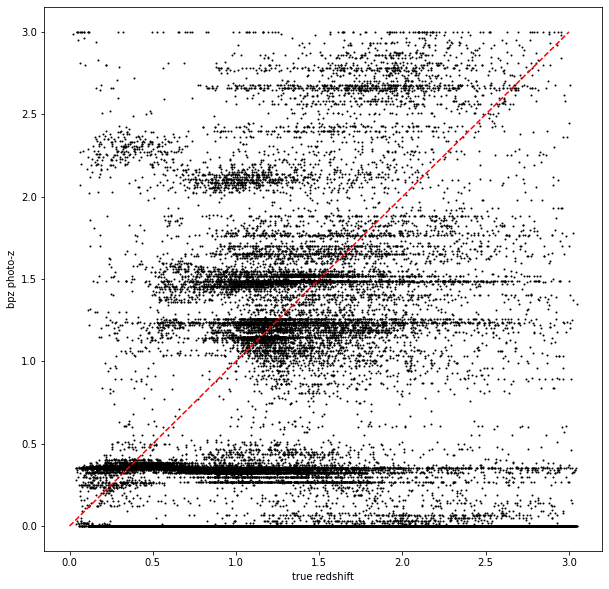

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(test_data()['redshift'],zmode,s=1,c='k')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

----------
## POSTERIOR - 2

In [57]:
estimate_bpz = BPZ_lite.make_stage(
    name='estimate_bpz', 
    hdf5_groupname='', 
    columns_file=columns_file, 
    model=inform_bpz.get_handle('model'),
    no_prior=True
)
bpz_estimated = estimate_bpz.estimate(test_data)

Process 0 running estimator on chunk 0 - 40406
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


In [58]:
test_data_orig = test_data.data

evaluator = Evaluator.make_stage(name=f'bpz_eval_2', truth=test_data_orig)
result_dict = evaluator.evaluate(bpz_estimated, test_data_orig)

results_tables = tables_io.convertObj(result_dict.data, tables_io.types.PD_DATAFRAME)
results_tables.head()

12608 PITs removed from the sample.


/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval_2: inprogress_output_bpz_eval_2.hdf5, bpz_eval_2
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'


,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,NaN,NaN,NaN,1.0,NaN,0.342118,-0.267309,0.007746,0.341964,NaN,NaN


Text(0, 0.5, 'bpz photo-z')

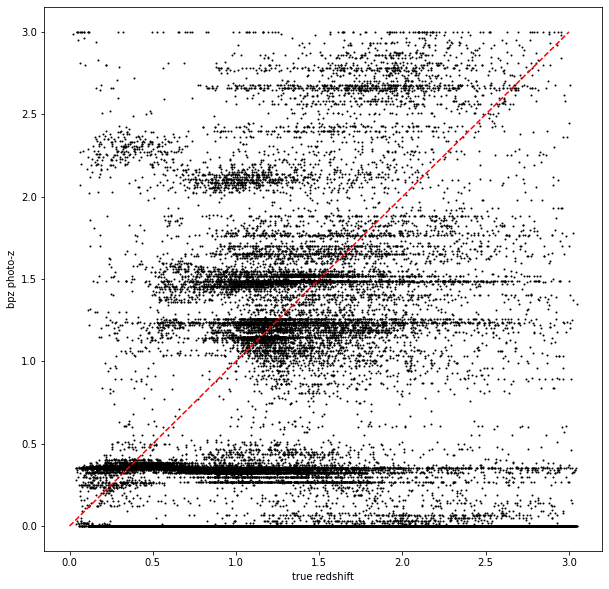

In [59]:
zmode = bpz_estimated().ancil['zmode']
plt.figure(figsize=(10,10))
plt.scatter(test_data()['redshift'],zmode,s=1,c='k',label='simple bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

-------
## POSTERIOR 3

In [60]:
estimate_bpz = BPZ_lite.make_stage(
    name='estimate_bpz', 
    hdf5_groupname='', 
    columns_file=columns_file, 
    model=inform_bpz.get_handle('model'),
    no_prior=True
)
bpz_estimated = estimate_bpz.estimate(test_data)

Process 0 running estimator on chunk 0 - 40406
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


In [61]:
test_data_orig = test_data.data

evaluator = Evaluator.make_stage(name=f'bpz_eval_3', truth=test_data_orig)
result_dict = evaluator.evaluate(bpz_estimated, test_data_orig)

results_tables = tables_io.convertObj(result_dict.data, tables_io.types.PD_DATAFRAME)
results_tables.head()

12608 PITs removed from the sample.


/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval_3: inprogress_output_bpz_eval_3.hdf5, bpz_eval_3
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'


,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,NaN,NaN,NaN,1.0,NaN,0.342118,-0.267309,0.007746,0.341964,NaN,NaN


Text(0, 0.5, 'bpz photo-z')

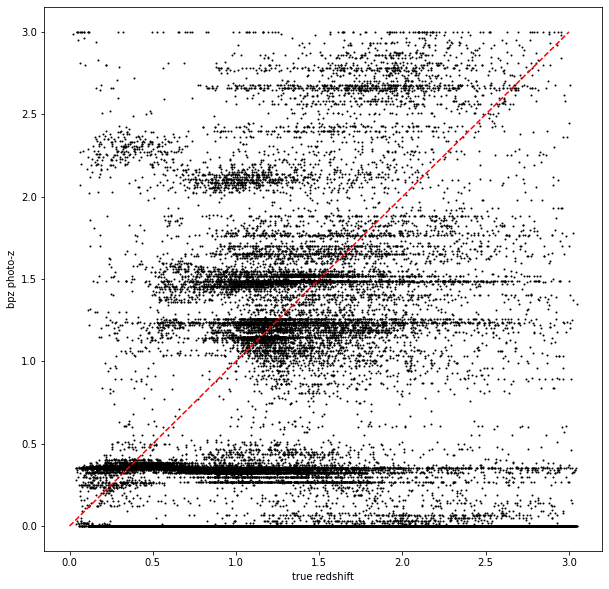

In [62]:
zmode = bpz_estimated().ancil['zmode']
plt.figure(figsize=(10,10))
plt.scatter(test_data()['redshift'],zmode,s=1,c='k',label='simple bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")